<a href="https://colab.research.google.com/github/jansoe/AICA/blob/main/Perzeptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Das Perzeptron

In [16]:
#@title Vorbereitungen 
#@markdown Hidden Code, bitte ausführen (Extra Funktionalitäten importieren)

# Importe für Extrafunktinonalität
import time
import numpy as np
import matplotlib.pyplot as plt

# und stellen noch die  Ausgabe ein
from matplotlib import rcParams
rcParams['figure.figsize'] = (5, 5)
rcParams['axes.grid'] = False

## Ein Lernbeispiel simulieren

Um unseren Lernalgorithmus auszuprobieren erstellen wir ein simuliertes Lernbeispiel:

* Es gibt 2 Klassen/Kategorien
  * Jede Klasse hat zwei verschiedene Eigenschaften

In [2]:
n_datenpunkte = 30 # Anzahl der Datenpunkte die wir simulieren
separation = 1 # Durschnitlicher Abstand beider Klassen zueinander
random_seed = 40 # Für jeden seed erhalten wir den gleichen Datensatz

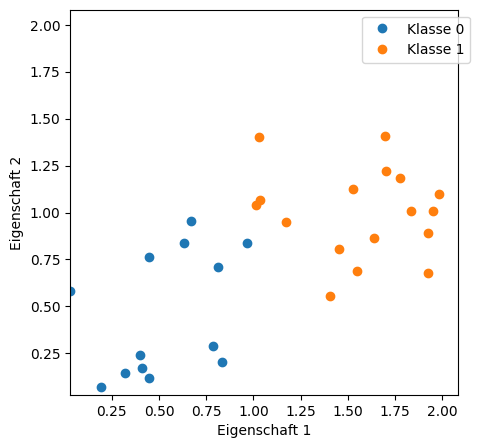

In [15]:
#@markdown Hidden Code,  bitte ausführen. (Code generiert ein Lernbeispiel) 

# In Anhängigkeit der oberen Parameter generieren wir hier den Datansazt
# und zeigen diesen zusätzlich an
np.random.seed(random_seed)

data = np.random.rand(n_datenpunkte,2)
targets = 1.*(np.random.rand(n_datenpunkte)<0.5)
data[targets==1, 0] += separation
data[targets==1, 1] += 0.5*separation
#data -= data.mean(axis=0)

# Funktion um den Datensatz zu plotten
def plot_data(data, targets, ax):
    
    ax.plot(data[targets==0,0], data[targets==0,1], 'o', label='Klasse 0')
    ax.plot(data[targets==1,0], data[targets==1,1], 'o', label='Klasse 1')

    minval = data.min()
    maxval = data.max()
    lim = [0.95*minval,1.05*maxval]    
    plt.ylim(lim)
    plt.xlim(lim)
    plt.xlabel("Eigenschaft 1")
    plt.ylabel("Eigenschaft 2")
    
    return lim
    
fig, ax = plt.subplots(figsize=(5,5))
# jetzt wird die funktion ausgeführt
_ = plot_data(data, targets, ax)
_ = plt.legend(bbox_to_anchor=(1.05, 1))

## Perceptron

### Definition

**Für einen Neustart des Perzeptron-Lernen hier neu beginnen**

Wir definieren jetzt ein Perceptron welches jedem 2d-Eingabepunkt `x` in eine Klasse (0 oder 1) zuordnet in Abhängigkeit der Parameter `w0, w1, theta`.

In [20]:
def perceptron(x, w0, w1, theta):
    activation = x[0]*w0 + x[1]*w1 + theta
    output = int(activation > 0)
    return output

für einen beliebig gewählten Parametersatz ...

In [21]:
w1 = 1
w0 = 0
theta = -1

bisherige_updates =  0 # Buchführung wie oft eine Update/Lernen stattgefunden hat

... gibt uns dann das Perceptron eine Klassenzuordnung:

In [22]:
x = [0, 0.5]
perceptron(x, w0, w1, theta)

0

D.h. mit dem Perceptron können wir jeden Punkt im Eigenschaftsraum klassifizieren:

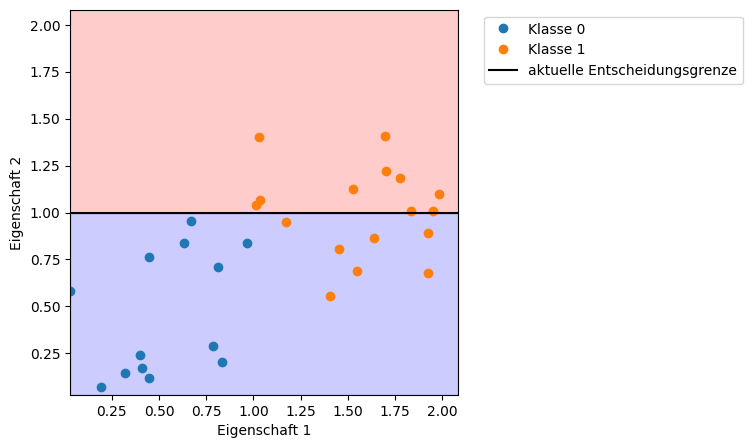

In [23]:
#@title
#@markdown ... Visualisierung der Klassifizierung ...

import time
import matplotlib
from google.colab import widgets

def plot_boundary(w0, w1, theta, lim, ax, background = True,  **kwargs):
    """ plot the decision boundary paramterized by w and theta within the bounds
        of a square described by lim."""
    
    if (w0==0) and (w1==0):
        x0 = lim
        x1 = [theta, theta] 
    elif w1 == 0:
        # senkrecht
        x0 = [-theta/w0]*2
        x1 = [lim]  
    else:
        x0 = lim
        #x1 = [(x*w0/w1 + theta) for x in x0]
        x1 = [(-x*w0 - theta)/w1 for x in x0]
    
    ax.plot(x0, x1, 'k', **kwargs)
    plt.xlim(lim)
    
    class_00=perceptron((x0[0], x0[0]), w0, w1, theta),
    if background:
        mi, ma = x0 
        b_x0, b_x1 = x1
        #color1 = 'b' if w0 < w1 else 'r'
        #color2 = 'r' if color1 == 'b' else 'b'
        color1 = 'b' if (class_00 and (b_x0 <0)) else 'r'
        color2 = 'r' if color1 == 'b' else 'b'
        area_0 = matplotlib.patches.Polygon(
            [(mi, b_x0), (ma, b_x1), (ma, ma), (mi, ma), (mi, b_x0)],
            #[(x0[0], x1[0]), (x0[1], x1[1]), 
            #(x0[1], x0[0]), (x0[0], x0[0]), 
            #(x0[0], x1[1]), (x0[0], x0[1]),
            #],
            alpha=0.2, color=color1
        )
        area_1 = matplotlib.patches.Polygon(
            [(mi, b_x0), (ma, b_x1), (ma, mi), (mi, mi), (mi, b_x0)],
            #[(x0[1], x0[1]), (x0[0], x0[1]), (x0[0], x1[0]), 
            #(x0[1], x1[1]), (x0[1], x0[0]), (x0[1], x1[0])],
            alpha=0.2, color=color2
        )
        plt.gca().add_patch(area_0)
        plt.gca().add_patch(area_1)


class TrennebenenPlotter():

    def __init__(self, data, targets, w0, w1, theta):

        self.data = data
        self.targets = targets
        self.w0_old = w0
        self.w1_old = w1
        self.theta_old = theta


    def plot_update(self, datenpunkt, w0, w1, theta, old=True):
        
        fig, ax = plt.subplots(figsize=(5,5))
        lim = plot_data(self.data, self.targets, ax)
        plot_boundary(w0, w1, theta, lim, ax, label='Entscheidungsgrenze aktuell')

        if old:
            plot_boundary(
                self.w0_old, self.w1_old, self.theta_old, lim, ax, 
                background = False, alpha=0.2, label='Entscheidungsgrenze vorher'
            )
            ax.plot(datenpunkt[0], datenpunkt[1], 'or', markersize = 10, mfc='none')
            _ = plt.legend(bbox_to_anchor=(1.05, 1))

        # wir speicher die alten Werte um das update spaeter zu visualisieren
        self.w0_old = w0
        self.w1_old = w1
        self.theta_old = theta


vis = TrennebenenPlotter(data, targets, w0, w1, theta)
fig, ax = plt.subplots(figsize = (5,5))
lim = plot_data(data, targets, ax)
_ = plot_boundary(w0,  w1, theta, lim, ax, 
    label="aktuelle Entscheidungsgrenze")
_ = plt.legend(bbox_to_anchor=(1.05, 1))


### Lernen

In [25]:
steps = 200 # Lernschritte:  Anzahl der Datenpunkte die auf einen Fehler untersucht und gegebenenfalls geupdate werden
lernrate = 0.1 # Wie stark die einzelnen Updateschritte sind

wait_time = 2 # Zeit zwischen 2 Schritten für die Anzeige (je länger desto mehr Zeit zum betrachten)

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

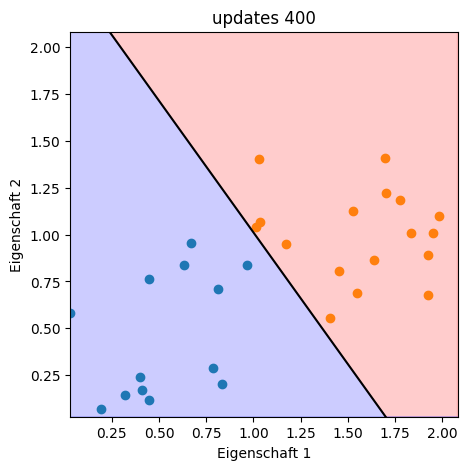

In [27]:
#@title

#@markdown Immer wenn ein falsch klassifizierter Punkt gefunden wird, wird das Update visualisiert.
#@markdown Öffnen Sie den Code wenn Sie die Lernregel interessiert!

grid = widgets.Grid(1, 1, header_row=False, header_column=False)
for i in range(steps):

    # wähle den nächsten Datenpunkt
    datenpunkt = data[bisherige_updates%len(data)]
    gewueschter_output = targets[bisherige_updates%len(data)]

    # berechne den Output
    perceptron_output = perceptron(datenpunkt, w0, w1, theta)

    # und vegleiche ihn mit dem gewünschten Output
    fehler = gewueschter_output - perceptron_output 

    if fehler != 0:
        # schiebe die Parameter (Trennebene) ein Stück in Richtung des falsch
        # kategorisierten Punkts
        w0 = w0 + lernrate * fehler * datenpunkt[0]
        w1 = w1 + lernrate * fehler * datenpunkt[1]   
        theta = theta + lernrate * fehler

        with grid.output_to(0, 0):
            grid.clear_cell()
            vis.plot_update(datenpunkt, w0, w1, theta)
            plt.title('updates '+str(bisherige_updates))
            plt.show()
        if steps > 1:
            time.sleep(wait_time)

    bisherige_updates += 1


with grid.output_to(0, 0):
    grid.clear_cell()
    vis.plot_update(datenpunkt, w0, w1, theta, old=False)
    plt.title('updates '+str(bisherige_updates))

## Aufgaben: Experimente

1. Varieren Sie die Lerneinstellungen. Was beobachten Sie?
  * `lernrate`: Wie stark die Gewichte bei jedem Klassifizierungsfehler verändert werden
  * `steps`: Wieviele Datenpunkte auf Fehler untersucht werden

2. Ändern Sie auch die Anfangsparameter (`w0`, `w1`, `theta`) des Perceptron. Was beobachten Sie?

3. Verringern Sie den Parameter `separation`. Was beobachten Sie?